In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import pandas as pd
import re
import seaborn as sns

/tmp/ipykernel_220722/3123374242.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_counts_vector(labels_vector):
    unique_labels, label_counts = np.unique(labels_vector, return_counts=True)
    counts_vector = np.zeros(21, dtype=int)
    counts_vector[unique_labels] = label_counts
    return counts_vector, unique_labels

sc_class_labels= ['eosinophil granulocyte', 'reactive lymphocyte',
       'neutrophil granulocyte (segmented)', 'typical lymphocyte',
       'other', 'neutrophil granulocyte (band)', 'monocyte',
       'large granulated lymphocyte', 'atypical promyelocyte',
       'basophil granulocyte', 'smudge cell', 'neoplastic lymphocyte',
       'promyelocyte', 'myelocyte', 'myeloblast', 'metamyelocyte',
       'normo', 'plasma cell', 'hair cell', 'bilobed M3v',
       'mononucleosis']

aml_class_labels = ["CBFB_MYH11","control","NPM1","PML_RARA","RUNX1_RUNX1T1"]

# Path to the folder containing your files
data_path = '/mnt/volume/shared/data_file/data'
result_path = '/mnt/volume/shared/data_file'

## Calculate Single Cell Classification counts 

In [8]:
def get_patient_name(path):
    return re.search(r"/data/\w+/([A-Z]{3})", path).group(1)

def get_class_name(path):
    return re.search(r"/data/(\w+)", path).group(1)

def get_image_number(path):
    return re.search(r"image_(\d).tif", path).group(1)

def get_classification_patient(patient_folder):
    probs_path = patient_folder + '/single_cell_probabilities.npy'
    sc_probs = np.load(probs_path)
    sc_class= np.argmax(sc_probs, axis=1)
    return sc_class

In [9]:
df = pd.DataFrame(columns=["patient","AML_subtype"]+sc_class_labels)
# Save class classification count for each patient in csv file
for folder_class in os.listdir(data_path):
    folder_class = os.path.join(data_path, folder_class)
    
    if os.path.isdir(folder_class):
       print(folder_class)
       for folder_patient in os.listdir(folder_class):
            folder_patient = os.path.join(folder_class, folder_patient)
            
            if os.path.isdir(folder_patient):
                if "single_cell_probabilities.npy" not in os.listdir(folder_patient):
                    print("Skipping patient folder without single_cell_probabilities.npy:", folder_patient)
                    continue
                sc_class = get_classification_patient(folder_patient)
                counts_vector,unique_labels = get_counts_vector(sc_class)
                df.loc[len(df)]=np.array([get_patient_name(folder_patient),get_class_name(folder_patient)]+counts_vector.tolist())

/mnt/volume/shared/data_file/data/control
/mnt/volume/shared/data_file/data/RUNX1_RUNX1T1
/mnt/volume/shared/data_file/data/CBFB_MYH11
/mnt/volume/shared/data_file/data/PML_RARA
/mnt/volume/shared/data_file/data/NPM1


In [10]:
df

,patient,AML_subtype,eosinophil granulocyte,reactive lymphocyte,neutrophil granulocyte (segmented),typical lymphocyte,other,neutrophil granulocyte (band),monocyte,large granulated lymphocyte,...,neoplastic lymphocyte,promyelocyte,myelocyte,myeloblast,metamyelocyte,normo,plasma cell,hair cell,bilobed M3v,mononucleosis
0,CIQ,control,1,0,67,13,26,1,7,7,...,0,0,0,0,1,0,3,0,0,0
1,FDW,control,6,4,89,59,33,2,15,7,...,0,0,0,0,1,0,8,1,0,6
2,ICS,control,11,19,128,39,122,2,26,7,...,5,0,0,1,1,0,0,0,0,0
3,WXO,control,4,3,128,34,95,6,16,10,...,0,0,0,0,0,1,2,0,0,9
4,NXO,control,18,25,256,50,36,5,28,26,...,0,0,0,1,2,1,17,1,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,UXN,NPM1,1,11,4,72,126,9,73,13,...,10,2,4,91,5,0,5,10,0,4
148,XFF,NPM1,1,0,1,9,35,1,0,8,...,0,6,7,275,3,0,2,4,0,7
149,ZEQ,NPM1,4,3,16,22,67,5,8,4,...,0,0,2,154,1,3,16,7,0,11
150,BHR,NPM1,11,2,8,23,40,8,34,10,...,2,3,2,305,0,1,7,4,0,7


In [14]:
df[sc_class_labels]=df[sc_class_labels].astype(int)
df[["patient","AML_subtype"]]=df[["patient","AML_subtype"]].astype(str)

In [15]:
df.to_csv(result_path+"/single_cell_results.csv")

In [4]:
df = pd.read_csv(result_path+"/single_cell_results.csv",index_col = 0)

In [7]:
df.dtypes

patient                               object
AML_subtype                           object
eosinophil granulocyte                 int64
reactive lymphocyte                    int64
neutrophil granulocyte (segmented)     int64
typical lymphocyte                     int64
other                                  int64
neutrophil granulocyte (band)          int64
monocyte                               int64
large granulated lymphocyte            int64
atypical promyelocyte                  int64
basophil granulocyte                   int64
smudge cell                            int64
neoplastic lymphocyte                  int64
promyelocyte                           int64
myelocyte                              int64
myeloblast                             int64
metamyelocyte                          int64
normo                                  int64
plasma cell                            int64
hair cell                              int64
bilobed M3v                            int64
mononucleo

## Perform Dunn's Test

In [8]:
import scikit_posthocs as sp
df_meanstd = df.drop("patient",axis=1).groupby(["AML_subtype"]).agg(["mean","std"])
df_meanstd

eosinophil granulocyte           reactive lymphocyte             \
                                mean       std                mean        std   
AML_subtype                                                                     
CBFB_MYH11                  3.466667  4.224178            4.800000   5.397317   
NPM1                        2.103448  2.769023            4.000000   5.976143   
PML_RARA                    0.842105  1.462994            2.947368   4.440642   
RUNX1_RUNX1T1               0.961538  1.182566            4.423077   4.708911   
control                     9.791667  8.233193           12.541667  15.513835   

              neutrophil granulocyte (segmented)             \
                                            mean        std   
AML_subtype                                                   
CBFB_MYH11                             11.300000  19.703229   
NPM1                                   29.827586  37.654509   
PML_RARA                               25.263158  31.790708   
RUNX1_RUNX1T1                          35.769231  37.164830   
control                               150.979167  79.452512   

              typical lymphocyte                 other             ...  \
                            mean        std       mean        std  ...   
AML_subtype                                                        ...   
CBFB_MYH11             58.933333  50.355929  52.133333  39.431943  ...   
NPM1                   48.620690  45.358425  63.965517  42.364475  ...   
PML_RARA               62.894737  87.069509  71.263158  35.719341  ...   
RUNX1_RUNX1T1          83.230769  53.273113  34.076923  22.833174  ...   
control                58.687500  36.115746  50.083333  34.435776  ...   

                  normo            plasma cell            hair cell            \
                   mean        std        mean        std      mean       std   
AML_subtype                                                                     
CBFB_MYH11     1.900000   2.708225   12.166667  25.677151  1.633333  3.438959   
NPM1           8.000000  25.546876   14.379310  34.497840  4.517241  5.138237   
PML_RARA       6.736842   6.797402    4.315789   4.269434  2.631579  3.530982   
RUNX1_RUNX1T1  2.615385   2.980965    5.923077   5.747508  1.461538  2.004610   
control        0.708333   1.320192    2.708333   5.031637  0.750000  1.120410   

              bilobed M3v            mononucleosis             
                     mean        std          mean        std  
AML_subtype                                                    
CBFB_MYH11       4.266667   9.089339     17.033333  21.507791  
NPM1             1.034483   2.146139     10.517241  11.525192  
PML_RARA        14.421053  48.088247      3.578947   4.463628  
RUNX1_RUNX1T1   10.769231  17.756819      8.846154   9.417823  
control          0.000000   0.000000      5.875000   6.303073  

[5 rows x 42 columns]

In [70]:
data = []
for aml_subtype in aml_class_labels:
    group = df_meanstd.loc[aml_subtype,:].loc[:,"mean"].values
    data.append(group)
posthoc_result = sp.posthoc_dunn(data, p_adjust = 'bonferroni')
table_df = pd.DataFrame(posthoc_result.values, index=aml_class_labels, columns=aml_class_labels)
table_df.to_csv("/home/hhauger/dunes_test.csv")
table_df

,CBFB_MYH11,control,NPM1,PML_RARA,RUNX1_RUNX1T1
CBFB_MYH11,1.000000,0.935316,1.000000,1.0,1.000000
control,0.935316,1.000000,0.517043,1.0,0.251265
NPM1,1.000000,0.517043,1.000000,1.0,1.000000
PML_RARA,1.000000,1.000000,1.000000,1.0,1.000000
RUNX1_RUNX1T1,1.000000,0.251265,1.000000,1.0,1.000000


##  Create plots with single cell classification counts

### Plot mean and standard deviation for all AML subtypes

In [29]:
figure_folder = "/home/hhauger/Figures"

/tmp/ipykernel_220722/3456695924.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="value", y="variable", hue="AML_subtype", data=melted_df,
/tmp/ipykernel_220722/3456695924.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.barplot(x="value", y="variable", hue="AML_subtype", data=melted_df,


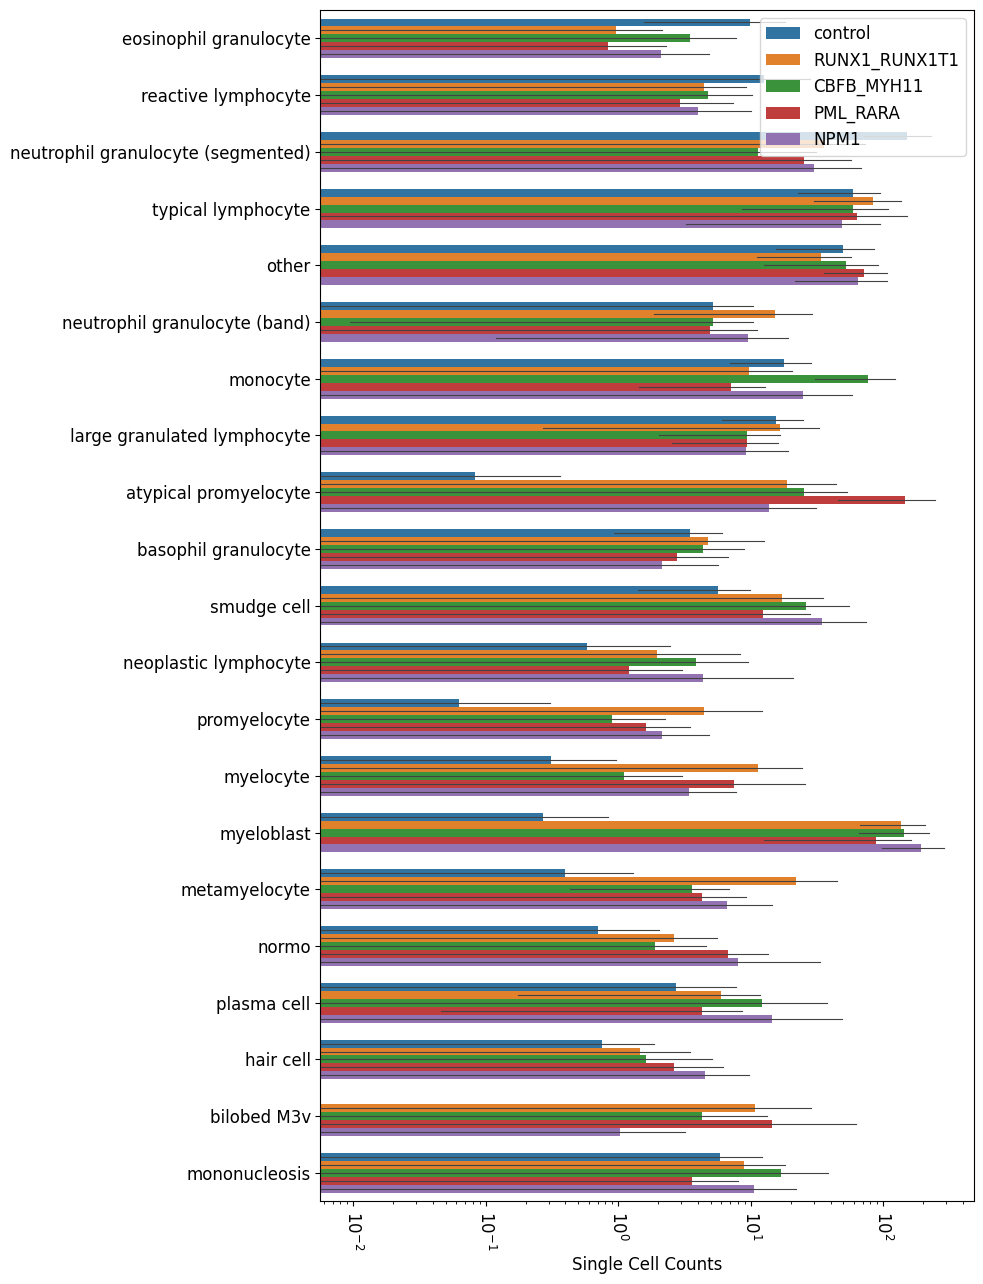

In [30]:
# Melt DataFrame to have a column for variable names
aml_class="NPM1"
plt.rcParams.update({'font.size': 12})
mask = df["AML_subtype"]==aml_class
melted_df = pd.melt(df, id_vars=["AML_subtype"], value_vars=df.columns[1:])

# Plotting using seaborn
plt.figure(figsize=(10, 13))
sns.barplot(x="value", y="variable", hue="AML_subtype", data=melted_df,
             ci="sd",orient='h', errwidth=0.8,  width=0.7)

# Set plot labels and title
plt.xlabel("Single Cell Counts")
plt.ylabel(None)
#plt.title(f"Mean and Standard Deviation for AML subtypes")
plt.xscale('log')
plt.xticks(rotation=-90)
plt.rcParams["figure.autolayout"] = True
plt.legend(loc=1)

# Set the rotation of the legend
# Show the plot
#plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig(figure_folder+"/overview_mean_std_sc_counts.png")

plt.show()


### Plot mean and standard deviation for each AML subtype individually

In [62]:
colorpalette = ['#2ca02c','#1f77b4','#9467bd','#d62728','#ff7f0e']
aml_class_labels

['CBFB_MYH11', 'control', 'NPM1', 'PML_RARA', 'RUNX1_RUNX1T1']

/tmp/ipykernel_220722/1824765446.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",
/tmp/ipykernel_220722/1824765446.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",


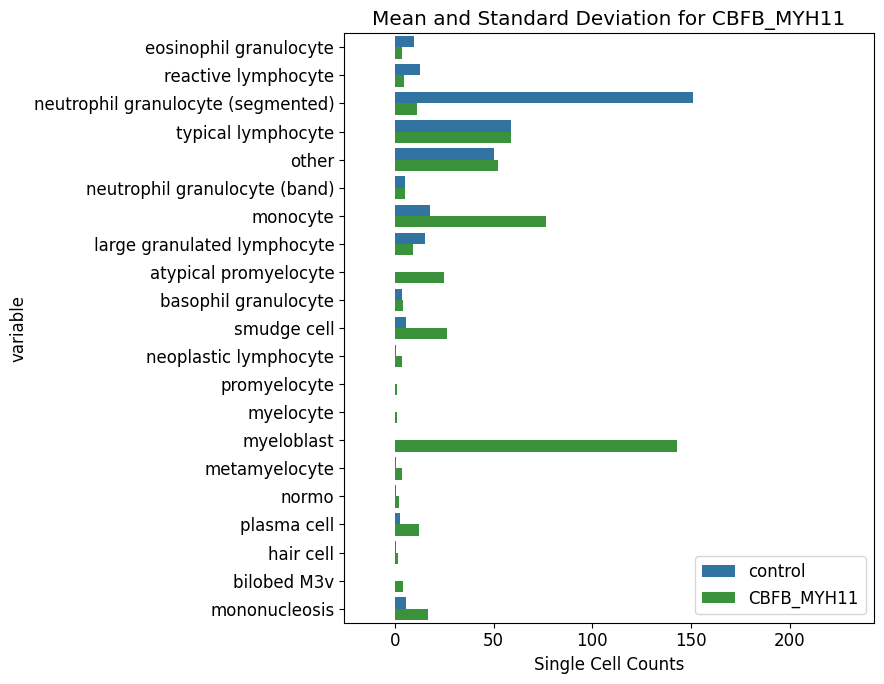

/tmp/ipykernel_220722/1824765446.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",
/tmp/ipykernel_220722/1824765446.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",


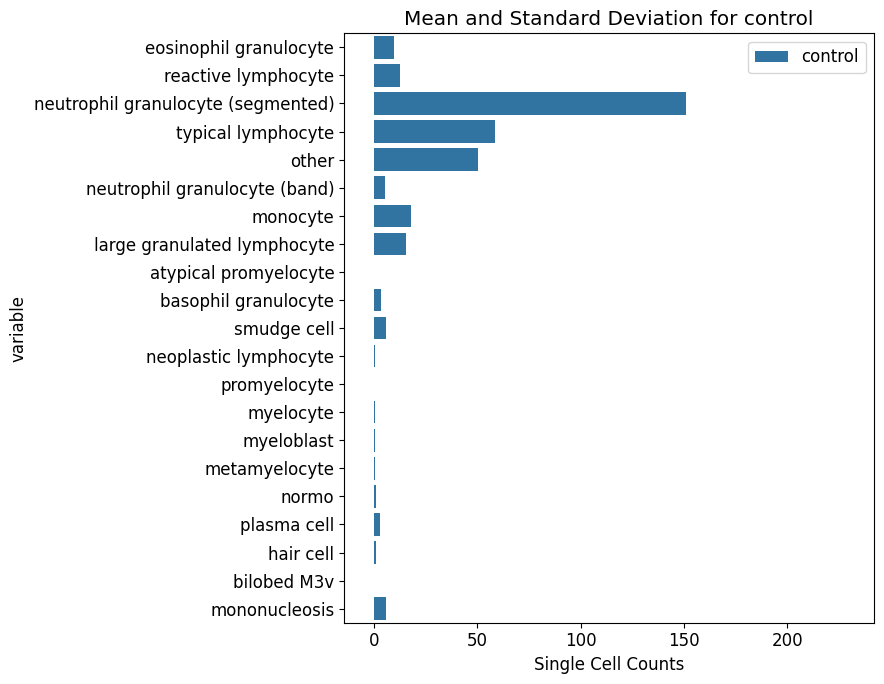

/tmp/ipykernel_220722/1824765446.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",
/tmp/ipykernel_220722/1824765446.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",


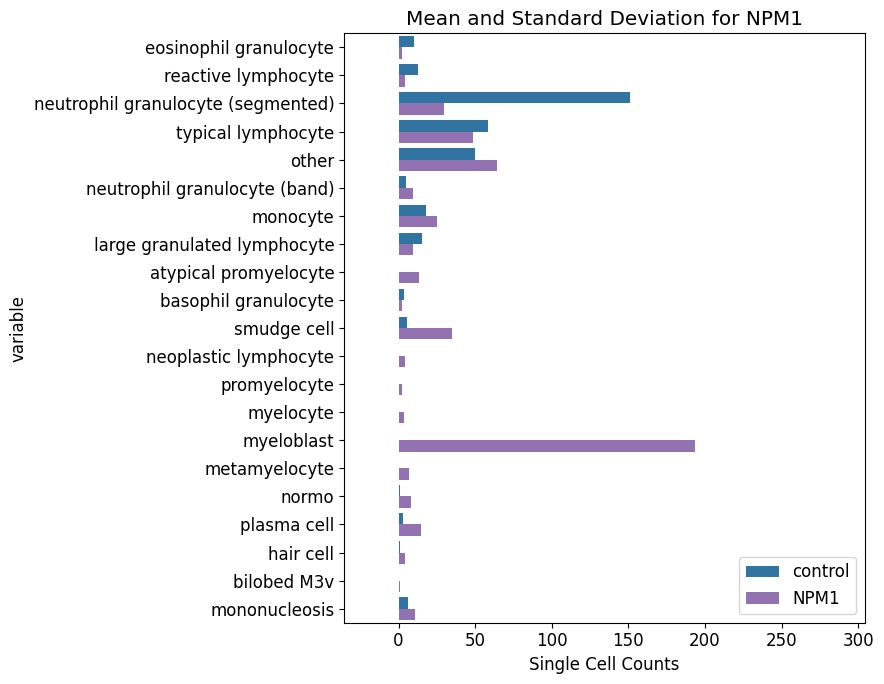

/tmp/ipykernel_220722/1824765446.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",
/tmp/ipykernel_220722/1824765446.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",


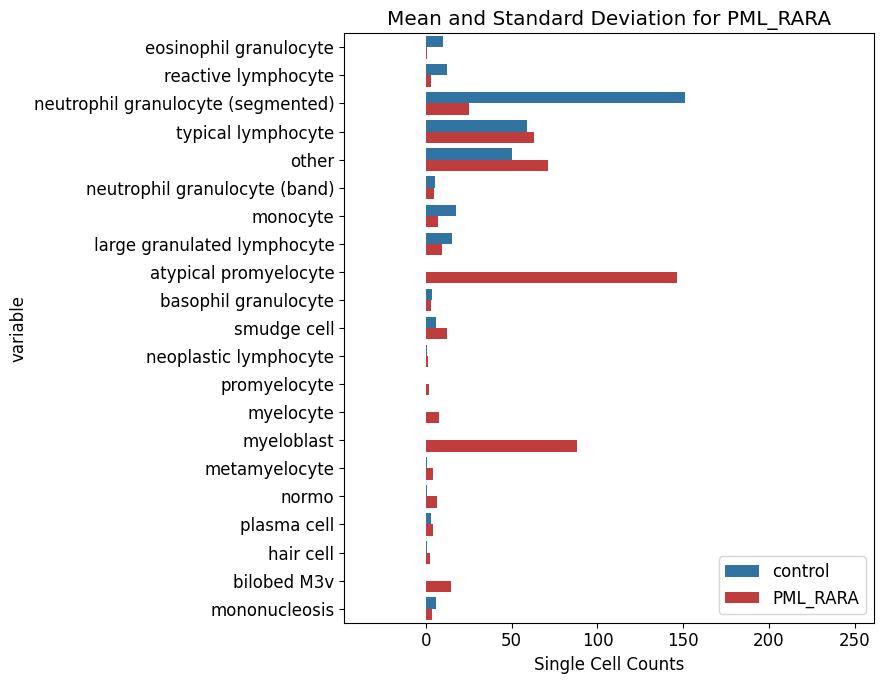

/tmp/ipykernel_220722/1824765446.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",
/tmp/ipykernel_220722/1824765446.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",


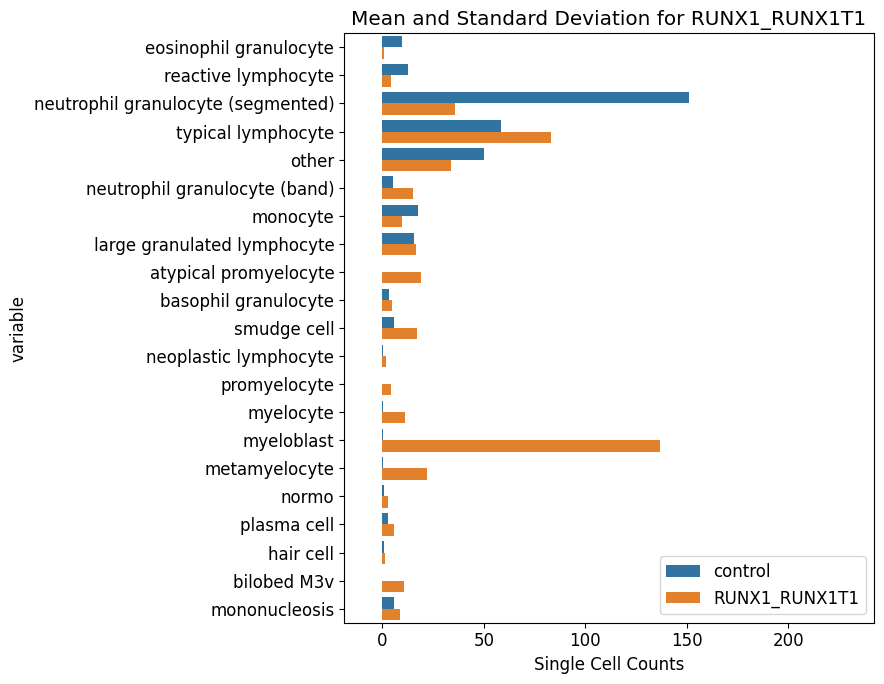

In [65]:
# Melt DataFrame to have a column for variable names
for i,aml_class in enumerate(aml_class_labels):
    mask = (df["AML_subtype"] == aml_class) | (df["AML_subtype"] == "control")
    melted_df = pd.melt(df[mask], id_vars=["AML_subtype"], value_vars=df.columns[1:])

    # Plotting using seaborn
    plt.figure(figsize=(9, 7))
    sns.barplot(x="value", y="variable", data=melted_df,hue="AML_subtype",
                 ci="sd",orient='h', errwidth=0,palette={aml_class: colorpalette[i], "control": colorpalette[1]})

    # Set plot labels and title
    plt.xlabel("Single Cell Counts")
    plt.title(f"Mean and Standard Deviation for {aml_class}")
    plt.xticks()
    plt.yticks(None)
    plt.legend()
    plt.savefig(figure_folder+f"/mean_std_sc_counts_{aml_class}.png")
    # Show the plot
    plt.show()


## Sample patients

In [48]:
aml_subtype = 'RUNX1_RUNX1T1'
#Get average length of images
avg_nimages = int(df[sc_class_labels].sum(axis=1).mean())
var_nimages = int(df[sc_class_labels].sum(axis=1).std())
print(f"Average Length {avg_nimages}")
print(f"Standard deviation of length {var_nimages}")

Average Length 444
Standard deviation of length 87


#### Sample data with np.choice

In [92]:
#get ratio for each cell with mean and std
df_ratio = df.drop("patient",axis=1).copy()
df_ratio[sc_class_labels] = df[sc_class_labels].div(df[sc_class_labels].sum(axis=1), axis=0)
df_ratio_mean = df_ratio.groupby(["AML_subtype"]).agg(["mean","std"])
df_ratio_mean

eosinophil granulocyte           reactive lymphocyte            \
                                mean       std                mean       std   
AML_subtype                                                                    
CBFB_MYH11                  0.002755  0.001678            0.016490  0.016575   
NPM1                        0.009380  0.011062            0.009270  0.013125   
PML_RARA                    0.002842  0.003072            0.005665  0.006721   
RUNX1_RUNX1T1               0.001610  0.003599            0.002015  0.002850   
control                     0.031260  0.012482            0.023235  0.017343   

              neutrophil granulocyte (segmented)           typical lymphocyte  \
                                            mean       std               mean   
AML_subtype                                                                     
CBFB_MYH11                              0.037199  0.034566           0.247359   
NPM1                                    0.065431  0.114657           0.156127   
PML_RARA                                0.025608  0.022611           0.080357   
RUNX1_RUNX1T1                           0.021195  0.021650           0.153468   
control                                 0.469608  0.070978           0.134266   

                            other            ...     normo            \
                    std      mean       std  ...      mean       std   
AML_subtype                                  ...                       
CBFB_MYH11     0.164566  0.056639  0.029123  ...  0.004153  0.005183   
NPM1           0.129897  0.100001  0.068876  ...  0.023490  0.032401   
PML_RARA       0.113220  0.179741  0.072589  ...  0.018498  0.033456   
RUNX1_RUNX1T1  0.159726  0.056273  0.031887  ...  0.009112  0.007504   
control        0.026111  0.172765  0.110505  ...  0.002062  0.004610   

              plasma cell           hair cell           bilobed M3v            \
                     mean       std      mean       std        mean       std   
AML_subtype                                                                     
CBFB_MYH11       0.014018  0.015685  0.003029  0.002524    0.002427  0.004395   
NPM1             0.015831  0.012501  0.014922  0.019776    0.005673  0.005266   
PML_RARA         0.008963  0.013152  0.004911  0.006873    0.032758  0.059347   
RUNX1_RUNX1T1    0.032422  0.022755  0.007496  0.007008    0.025365  0.025638   
control          0.006133  0.011060  0.002522  0.001828    0.000000  0.000000   

              mononucleosis            
                       mean       std  
AML_subtype                            
CBFB_MYH11         0.026321  0.031733  
NPM1               0.025404  0.035754  
PML_RARA           0.005680  0.007779  
RUNX1_RUNX1T1      0.012711  0.013951  
control            0.011180  0.010963  

[5 rows x 42 columns]

In [146]:
#Sample data with np.choice and mean ratios for each plot
#Your observed class proportions (replace this with your actual data)
observed_class_proportions = df_ratio_mean.loc[aml_subtype,:].loc[:,"mean"].values
num_classes = len(observed_class_proportions)

num_samples = int(np.random.normal(loc=avg_nimages, scale=var_nimages))
print(f"Total number of samples: {num_samples}")

new_data = np.random.choice(sc_class_labels, size=num_samples, p=observed_class_proportions)

# Print the distribution of the new data
unique_classes, counts = np.unique(new_data, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"{count} \t  {cls}")

Total number of samples: 340
7 	  atypical promyelocyte
2 	  basophil granulocyte
7 	  bilobed M3v
2 	  hair cell
3 	  large granulated lymphocyte
16 	  metamyelocyte
27 	  monocyte
4 	  mononucleosis
151 	  myeloblast
5 	  myelocyte
5 	  neutrophil granulocyte (band)
4 	  neutrophil granulocyte (segmented)
3 	  normo
13 	  other
12 	  plasma cell
8 	  promyelocyte
1 	  reactive lymphocyte
18 	  smudge cell
52 	  typical lymphocyte


### Sample data with normal distribution

In [147]:
# Sample data with normal distribution
class_means = df_meanstd.loc[aml_subtype,:].loc[:,"mean"].values
class_variances = df_meanstd.loc[aml_subtype,:].loc[:,"std"].values

# Generate new data based on multivariate Gaussian distribution for each class
generated_data = np.random.normal(class_means,class_variances,21).astype(int)
generated_data = generated_data*(generated_data>0)

print(f"Total number of samples: {np.sum(generated_data)}")
for cls, count in zip(sc_class_labels, generated_data):
        print(f"{count} \t  {cls}")

Total number of samples: 461
0 	  eosinophil granulocyte
0 	  reactive lymphocyte
13 	  neutrophil granulocyte (segmented)
0 	  typical lymphocyte
26 	  other
0 	  neutrophil granulocyte (band)
16 	  monocyte
6 	  large granulated lymphocyte
13 	  atypical promyelocyte
0 	  basophil granulocyte
7 	  smudge cell
0 	  neoplastic lymphocyte
15 	  promyelocyte
5 	  myelocyte
291 	  myeloblast
22 	  metamyelocyte
12 	  normo
11 	  plasma cell
10 	  hair cell
14 	  bilobed M3v
0 	  mononucleosis
